In [63]:
from typing import Annotated
from typing_extensions import TypedDict


In [64]:
# working with tool
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

arxiv_wrapper  = ArxivAPIWrapper(top_k=2,doc_content_charss_max =300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)

wikipedia_wrapper  = WikipediaAPIWrapper(top_k=1,doc_content_charss_max =300)
wiki_tool = WikipediaQueryRun(api_wrapper=wikipedia_wrapper)

In [65]:
wiki_tool.invoke("what is India?")

"Page: India\nSummary: India, officially the Republic of India, is a country in South Asia.  It is the seventh-largest country by area; the most populous country since 2023; and, since its independence in 1947, the world's most populous democracy. Bounded by the Indian Ocean on the south, the Arabian Sea on the southwest, and the Bay of Bengal on the southeast, it shares land borders with Pakistan to the west; China, Nepal, and Bhutan to the north; and Bangladesh and Myanmar to the east. In the Indian Ocean, India is near Sri Lanka and the Maldives; its Andaman and Nicobar Islands share a maritime border with Thailand, Myanmar, and Indonesia.\nModern humans arrived on the Indian subcontinent from Africa no later than 55,000 years ago. Their long occupation, predominantly in isolation as hunter-gatherers, has made the region highly diverse. Settled life emerged on the subcontinent in the western margins of the Indus river basin 9,000 years ago, evolving gradually into the Indus Valley C

In [66]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time on the performance of\nLlama-v2 models. We find that dropping dreeper attention layers only marginally\ndecreases performance but leads to the best speedups alongside dropping entire\nlayers. For example, removing 33\\% of attention layers in a 13B Llama2 model\nresults in a 1.8\\% drop in average performance over the OpenLLM benchmark. We\nalso observe that skipping layers except the latter layers reduces performances\nfor more layers skipped, except for skipping the attention layers.\n\n

In [67]:
tools = [wiki_tool,arxiv_tool] 

In [68]:
##langg graph applications
from langgraph.graph.message import add_messages 
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [69]:
from langgraph.graph import StateGraph,START,END

graph_builder=StateGraph(State)

In [70]:
#import environment variables
import os
from dotenv import load_dotenv
load_dotenv()

groq_api_key = os.getenv("Groq_api")


In [71]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.3-70b-versatile",groq_api_key=groq_api_key)
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001B7E3825510>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001B7E3769950>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [72]:
llm_with_tools=llm.bind_tools(tools)

In [73]:
def bot(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


In [74]:
from langgraph.prebuilt import  ToolNode,tools_condition

In [75]:
graph_builder.add_node("bot",bot)     
graph_builder.add_edge(START,"bot")
tool_node = ToolNode(tools=tools)

graph_builder.add_node("tools",tool_node)

graph_builder.add_conditional_edges(
    "bot",
    tools_condition
    )
graph_builder.add_edge("tools","bot")
graph_builder.add_edge("bot",END)

In [76]:
graph=graph_builder.compile()


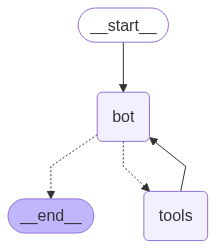

In [77]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [83]:
user_input="What is Langchain?"

events = graph.stream(
    {"messages": [("user",user_input)]},stream_mode = "values"
)

for event in events:
    event["messages"] [-1].pretty_print()

================================ Human Message =================================

What is Langchain?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (n9ns5gege)
 Call ID: n9ns5gege
  Args:
    query: Langchain
================================= Tool Message =================================
Name: wikipedia

Page: LangChain
Summary: LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.

Page: Milvus (vector database)
Summary: Milvus is a distributed vector database developed by Zilliz. It is available as both open-source software and a cloud service.
Milvus is an open-source project under LF AI & Data Foundation distributed under the Apache License 2.0.



Page: Retrie